In [1]:
import pandas as pd
import numpy as np
import cx_Oracle
import os
import json
import datetime
import warnings
import matplotlib.pyplot as plt
warnings.filterwarnings(action="ignore")
from selenium import webdriver
from selenium.webdriver.support.ui import Select
from selenium.webdriver.common.by import By
import bs4
import requests
import time
import math
import random
from shapely.geometry import Point, Polygon
import time as timesys
from pyproj import Geod
from haversine import haversine
pd.set_option('display.max_columns', None)

In [2]:
voyage_list = []
waiting_list = []

In [3]:
vessel_name = 'OOCL_LUXEMBOURG'

In [4]:
cf_port_mis_df = pd.read_csv(f"voy_path/{vessel_name}_portmis.csv")
cf_port_mis_df

,voyage_name,port_in_time,port_out_time,next_port,previous_port
0,VRGO3_2022_4,2022-08-13 00:00:00,2022-08-13 21:52:00,SHANGHAI,XINGANG
1,VRGO3_2022_5,2022-10-02 00:14:00,2022-10-02 21:02:00,SHANGHAI,TIANJIN XINGANG PT
2,VRGO3_2022_6,2022-11-26 00:10:00,2022-11-26 11:55:00,SHANGHAI,TIANJIN PT


In [5]:
tos_plan_berth = pd.read_csv("tos_plan_berth.csv")


In [6]:
time_before = cf_port_mis_df.loc[0,"port_out_time"]
time_before = pd.to_datetime(time_before)
time_after = cf_port_mis_df.loc[2,"port_out_time"]
time_after = pd.to_datetime(time_after)


In [7]:
tos_plan_berth["timestamp"] =pd.to_datetime(tos_plan_berth["timestamp"] )

In [8]:
pnit_history = pd.read_excel("pnit_berth_history_2.xlsx")
VSL_CD = pnit_history.query(f"선명 == '{vessel_name.replace('_',' ')}'")["모선항차"].values[0][:4]
VSL_CD

'OOLU'

In [9]:
tos_plan_oolu = tos_plan_berth[(tos_plan_berth["timestamp"] > time_before) & (tos_plan_berth["timestamp"] < time_after )]
# tos_plan_oony = tos_plan_berth[tos_plan_berth["timestamp"] < time_after]
tos_plan_oolu.reset_index(inplace=True, drop=True)

In [10]:
# tos_plan_oolu

In [11]:
tos_plan_oolu = tos_plan_oolu.query(f'VSL_CD == "{VSL_CD}"')
tos_plan_oolu

,TML_NUM,TML_CD,TML_CUD,VSL_CD,CALL_YEAR,CALL_SEQ,VOYAGE,PTNR_CODE,BERTH_NO,ALONG_SIDE,FROM_BITT,TO_BITT,ETA,ETB,ETW,ETC,ETD,ATA,ATB,ATW,ATC,ATD,YARD_OPEN,YARD_CLOSE,DIS_QTY,LOAD_QTY,UPDATE_TIME,timestamp
10265,1973,PNIT,U,OOLU,2022,6,OOLU006,OOL,OT,P,51.0,XX,2022-09-30 16:00:00,2022-09-30 17:00:00,NaN,NaN,2022-10-01 12:00:00,NaN,NaN,NaN,NaN,NaN,2022-09-27 17:00:00,2022-09-30 07:00:00,600,500,2022-09-16 15:06:28,2022-09-17 00:10:06.009198
10316,1973,PNIT,U,OOLU,2022,6,OOLU006,OOL,OT,P,51.0,XX,2022-09-30 16:00:00,2022-09-30 17:00:00,NaN,NaN,2022-10-01 12:00:00,NaN,NaN,NaN,NaN,NaN,2022-09-27 17:00:00,2022-09-30 07:00:00,600,500,2022-09-16 15:06:28,2022-09-17 00:31:46.288547
10367,1973,PNIT,U,OOLU,2022,6,OOLU006,OOL,OT,P,51.0,XX,2022-09-30 16:00:00,2022-09-30 17:00:00,NaN,NaN,2022-10-01 12:00:00,NaN,NaN,NaN,NaN,NaN,2022-09-27 17:00:00,2022-09-30 07:00:00,600,500,2022-09-16 15:06:28,2022-09-17 00:40:08.396612
10418,1973,PNIT,U,OOLU,2022,6,OOLU006,OOL,OT,P,51.0,XX,2022-09-30 16:00:00,2022-09-30 17:00:00,NaN,NaN,2022-10-01 12:00:00,NaN,NaN,NaN,NaN,NaN,2022-09-27 17:00:00,2022-09-30 07:00:00,600,500,2022-09-16 15:06:28,2022-09-17 01:10:10.920011
10469,1973,PNIT,U,OOLU,2022,6,OOLU006,OOL,OT,P,51.0,XX,2022-09-30 16:00:00,2022-09-30 17:00:00,NaN,NaN,2022-10-01 12:00:00,NaN,NaN,NaN,NaN,NaN,2022-09-27 17:00:00,2022-09-30 07:00:00,600,500,2022-09-16 15:06:28,2022-09-17 01:40:13.581402
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
863055,2243,PNIT,U,OOLU,2022,7,OOLU007,OOL,T1,P,1.0,21,2022-11-25 23:00:00,2022-11-26 00:00:00,NaN,NaN,2022-11-26 14:00:00,NaN,NaN,NaN,NaN,NaN,2022-11-19 00:00:00,2022-11-25 14:00:00,665,479,2022-11-25 21:14:46,2022-11-25 21:35:49.187359
863174,2243,PNIT,U,OOLU,2022,7,OOLU007,OOL,T1,P,1.0,21,2022-11-25 23:00:00,2022-11-26 00:00:00,NaN,NaN,2022-11-26 14:00:00,NaN,NaN,NaN,NaN,NaN,2022-11-19 00:00:00,2022-11-25 14:00:00,665,479,2022-11-25 21:14:46,2022-11-25 21:40:51.077017
863293,2243,PNIT,U,OOLU,2022,7,OOLU007,OOL,T1,P,1.0,21,2022-11-25 23:00:00,2022-11-26 00:00:00,NaN,NaN,2022-11-26 14:00:00,NaN,NaN,NaN,NaN,NaN,2022-11-19 00:00:00,2022-11-25 14:00:00,665,479,2022-11-25 21:14:46,2022-11-25 21:45:53.658598
863412,2243,PNIT,U,OOLU,2022,7,OOLU007,OOL,T1,P,1.0,21,2022-11-25 23:00:00,2022-11-26 00:00:00,NaN,NaN,2022-11-26 14:00:00,NaN,NaN,NaN,NaN,NaN,2022-11-19 00:00:00,2022-11-25 14:00:00,665,479,2022-11-25 21:14:46,2022-11-25 23:20:34.870542


In [12]:
set(tos_plan_oolu.sort_values(by="VOYAGE")['VOYAGE'].values)

{'OOLU001',
 'OOLU002',
 'OOLU003',
 'OOLU004',
 'OOLU005',
 'OOLU006',
 'OOLU007',
 'OOLU008'}

In [13]:
voyages = list(set(tos_plan_oolu.sort_values(by="VOYAGE")['VOYAGE'].values))
for voyage in voyages:
    df = tos_plan_oolu.query(f'VOYAGE == "{voyage}"')
    df.reset_index(inplace=True, drop=True)
    globals()[voyage + "_df"] = df
    display(df)

,TML_NUM,TML_CD,TML_CUD,VSL_CD,CALL_YEAR,CALL_SEQ,VOYAGE,PTNR_CODE,BERTH_NO,ALONG_SIDE,FROM_BITT,TO_BITT,ETA,ETB,ETW,ETC,ETD,ATA,ATB,ATW,ATC,ATD,YARD_OPEN,YARD_CLOSE,DIS_QTY,LOAD_QTY,UPDATE_TIME,timestamp
0,1294,PNIT,U,OOLU,2022,2,OOLU002,OOL,T3,P,42.0,62,2022-03-13 11:00:00,2022-03-13 19:00:00,NaN,NaN,2022-03-14 21:00:00,NaN,2022-03-13 19:00:00,2022-03-13 20:02:00,2022-03-14 20:55:00,2022-03-14 21:00:00,2022-03-10 19:00:00,2022-03-13 02:00:00,1585,576,2022-03-18 13:39:28,2022-10-19 17:00:33.397252
1,1294,PNIT,U,OOLU,2022,2,OOLU002,OOL,T3,P,42.0,62,2022-03-13 11:00:00,2022-03-13 19:00:00,NaN,NaN,2022-03-14 21:00:00,NaN,2022-03-13 19:00:00,2022-03-13 20:02:00,2022-03-14 20:55:00,2022-03-14 21:00:00,2022-03-10 19:00:00,2022-03-13 02:00:00,1585,576,2022-03-18 13:39:28,2022-10-19 17:01:30.995609
2,1294,PNIT,U,OOLU,2022,2,OOLU002,OOL,T3,P,42.0,62,2022-03-13 11:00:00,2022-03-13 19:00:00,NaN,NaN,2022-03-14 21:00:00,NaN,2022-03-13 19:00:00,2022-03-13 20:02:00,2022-03-14 20:55:00,2022-03-14 21:00:00,2022-03-10 19:00:00,2022-03-13 02:00:00,1585,576,2022-03-18 13:39:28,2022-10-19 17:08:28.754177


,TML_NUM,TML_CD,TML_CUD,VSL_CD,CALL_YEAR,CALL_SEQ,VOYAGE,PTNR_CODE,BERTH_NO,ALONG_SIDE,FROM_BITT,TO_BITT,ETA,ETB,ETW,ETC,ETD,ATA,ATB,ATW,ATC,ATD,YARD_OPEN,YARD_CLOSE,DIS_QTY,LOAD_QTY,UPDATE_TIME,timestamp
0,1740,PNIT,U,OOLU,2022,4,OOLU004,OOL,T2,P,21.0,41,2022-06-24 16:00:00,2022-06-24 17:00:00,NaN,NaN,2022-06-25 12:00:00,NaN,NaN,NaN,NaN,NaN,2022-06-21 17:00:00,2022-06-24 07:00:00,600,500,2022-06-03 11:38:58,2022-10-19 17:00:33.397252
1,1740,PNIT,U,OOLU,2022,4,OOLU004,OOL,T2,P,21.0,41,2022-06-24 16:00:00,2022-06-24 17:00:00,NaN,NaN,2022-06-25 12:00:00,NaN,NaN,NaN,NaN,NaN,2022-06-21 17:00:00,2022-06-24 07:00:00,600,500,2022-06-03 11:38:58,2022-10-19 17:01:30.995609
2,1740,PNIT,U,OOLU,2022,4,OOLU004,OOL,T2,P,21.0,41,2022-06-24 16:00:00,2022-06-24 17:00:00,NaN,NaN,2022-06-25 12:00:00,NaN,NaN,NaN,NaN,NaN,2022-06-21 17:00:00,2022-06-24 07:00:00,600,500,2022-06-03 11:38:58,2022-10-19 17:08:28.754177


,TML_NUM,TML_CD,TML_CUD,VSL_CD,CALL_YEAR,CALL_SEQ,VOYAGE,PTNR_CODE,BERTH_NO,ALONG_SIDE,FROM_BITT,TO_BITT,ETA,ETB,ETW,ETC,ETD,ATA,ATB,ATW,ATC,ATD,YARD_OPEN,YARD_CLOSE,DIS_QTY,LOAD_QTY,UPDATE_TIME,timestamp
0,1094,PNIT,U,OOLU,2022,1,OOLU001,OOL,T2,P,20.0,40,2022-01-16 08:00:00,2022-01-16 12:00:00,NaN,NaN,2022-01-17 13:00:00,NaN,2022-01-16 12:05:00,2022-01-16 13:08:00,2022-01-17 12:25:00,2022-01-17 13:00:00,2022-01-13 09:00:00,2022-01-15 23:00:00,1267,527,2022-01-20 11:42:32,2022-10-19 17:00:33.397252
1,1004,PNIT,C,OOLU,2021,1,OOLU001,OOL,T2,P,19.0,39,2021-11-22 05:00:00,2021-11-22 06:00:00,2021-11-22 18:00:00,NaN,2021-11-23 07:00:00,NaN,2021-11-22 06:10:00,2021-11-22 18:50:00,2021-11-23 05:27:00,2021-11-23 07:00:00,2021-11-17 06:00:00,2021-11-21 16:00:00,609,506,2021-11-23 08:26:13,2022-10-19 17:00:33.397252
2,1094,PNIT,U,OOLU,2022,1,OOLU001,OOL,T2,P,20.0,40,2022-01-16 08:00:00,2022-01-16 12:00:00,NaN,NaN,2022-01-17 13:00:00,NaN,2022-01-16 12:05:00,2022-01-16 13:08:00,2022-01-17 12:25:00,2022-01-17 13:00:00,2022-01-13 09:00:00,2022-01-15 23:00:00,1267,527,2022-01-20 11:42:32,2022-10-19 17:01:30.995609
3,1004,PNIT,C,OOLU,2021,1,OOLU001,OOL,T2,P,19.0,39,2021-11-22 05:00:00,2021-11-22 06:00:00,2021-11-22 18:00:00,NaN,2021-11-23 07:00:00,NaN,2021-11-22 06:10:00,2021-11-22 18:50:00,2021-11-23 05:27:00,2021-11-23 07:00:00,2021-11-17 06:00:00,2021-11-21 16:00:00,609,506,2021-11-23 08:26:13,2022-10-19 17:01:30.995609
4,1094,PNIT,U,OOLU,2022,1,OOLU001,OOL,T2,P,20.0,40,2022-01-16 08:00:00,2022-01-16 12:00:00,NaN,NaN,2022-01-17 13:00:00,NaN,2022-01-16 12:05:00,2022-01-16 13:08:00,2022-01-17 12:25:00,2022-01-17 13:00:00,2022-01-13 09:00:00,2022-01-15 23:00:00,1267,527,2022-01-20 11:42:32,2022-10-19 17:08:28.754177
5,1004,PNIT,C,OOLU,2021,1,OOLU001,OOL,T2,P,19.0,39,2021-11-22 05:00:00,2021-11-22 06:00:00,2021-11-22 18:00:00,NaN,2021-11-23 07:00:00,NaN,2021-11-22 06:10:00,2021-11-22 18:50:00,2021-11-23 05:27:00,2021-11-23 07:00:00,2021-11-17 06:00:00,2021-11-21 16:00:00,609,506,2021-11-23 08:26:13,2022-10-19 17:08:28.754177


,TML_NUM,TML_CD,TML_CUD,VSL_CD,CALL_YEAR,CALL_SEQ,VOYAGE,PTNR_CODE,BERTH_NO,ALONG_SIDE,FROM_BITT,TO_BITT,ETA,ETB,ETW,ETC,ETD,ATA,ATB,ATW,ATC,ATD,YARD_OPEN,YARD_CLOSE,DIS_QTY,LOAD_QTY,UPDATE_TIME,timestamp
0,2243,PNIT,C,OOLU,2022,7,OOLU007,OOL,T2,P,NaN,NaN,2022-11-25 16:00:00,2022-11-25 17:00:00,NaN,NaN,2022-11-26 12:00:00,NaN,NaN,NaN,NaN,NaN,2022-10-25 17:00:00,2022-11-25 07:00:00,600,500,NaN,2022-11-02 14:47:18.553373
1,2243,PNIT,C,OOLU,2022,7,OOLU007,OOL,T2,P,NaN,NaN,2022-11-25 16:00:00,2022-11-25 17:00:00,NaN,NaN,2022-11-26 12:00:00,NaN,NaN,NaN,NaN,NaN,2022-10-25 17:00:00,2022-11-25 07:00:00,600,500,NaN,2022-11-02 14:52:58.313738
2,2243,PNIT,C,OOLU,2022,7,OOLU007,OOL,T2,P,NaN,NaN,2022-11-25 16:00:00,2022-11-25 17:00:00,NaN,NaN,2022-11-26 12:00:00,NaN,NaN,NaN,NaN,NaN,2022-10-25 17:00:00,2022-11-25 07:00:00,600,500,NaN,2022-11-02 14:57:24.779752
3,2243,PNIT,C,OOLU,2022,7,OOLU007,OOL,T2,P,NaN,NaN,2022-11-25 16:00:00,2022-11-25 17:00:00,NaN,NaN,2022-11-26 12:00:00,NaN,NaN,NaN,NaN,NaN,2022-10-25 17:00:00,2022-11-25 07:00:00,600,500,NaN,2022-11-02 15:12:38.443702
4,2243,PNIT,C,OOLU,2022,7,OOLU007,OOL,T2,P,NaN,NaN,2022-11-25 16:00:00,2022-11-25 17:00:00,NaN,NaN,2022-11-26 12:00:00,NaN,NaN,NaN,NaN,NaN,2022-10-25 17:00:00,2022-11-25 07:00:00,600,500,NaN,2022-11-02 15:17:35.608925
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6067,2243,PNIT,U,OOLU,2022,7,OOLU007,OOL,T1,P,1.0,21,2022-11-25 23:00:00,2022-11-26 00:00:00,NaN,NaN,2022-11-26 14:00:00,NaN,NaN,NaN,NaN,NaN,2022-11-19 00:00:00,2022-11-25 14:00:00,665,479,2022-11-25 21:14:46,2022-11-25 21:35:49.187359
6068,2243,PNIT,U,OOLU,2022,7,OOLU007,OOL,T1,P,1.0,21,2022-11-25 23:00:00,2022-11-26 00:00:00,NaN,NaN,2022-11-26 14:00:00,NaN,NaN,NaN,NaN,NaN,2022-11-19 00:00:00,2022-11-25 14:00:00,665,479,2022-11-25 21:14:46,2022-11-25 21:40:51.077017
6069,2243,PNIT,U,OOLU,2022,7,OOLU007,OOL,T1,P,1.0,21,2022-11-25 23:00:00,2022-11-26 00:00:00,NaN,NaN,2022-11-26 14:00:00,NaN,NaN,NaN,NaN,NaN,2022-11-19 00:00:00,2022-11-25 14:00:00,665,479,2022-11-25 21:14:46,2022-11-25 21:45:53.658598
6070,2243,PNIT,U,OOLU,2022,7,OOLU007,OOL,T1,P,1.0,21,2022-11-25 23:00:00,2022-11-26 00:00:00,NaN,NaN,2022-11-26 14:00:00,NaN,NaN,NaN,NaN,NaN,2022-11-19 00:00:00,2022-11-25 14:00:00,665,479,2022-11-25 21:14:46,2022-11-25 23:20:34.870542


,TML_NUM,TML_CD,TML_CUD,VSL_CD,CALL_YEAR,CALL_SEQ,VOYAGE,PTNR_CODE,BERTH_NO,ALONG_SIDE,FROM_BITT,TO_BITT,ETA,ETB,ETW,ETC,ETD,ATA,ATB,ATW,ATC,ATD,YARD_OPEN,YARD_CLOSE,DIS_QTY,LOAD_QTY,UPDATE_TIME,timestamp
0,1445,PNIT,U,OOLU,2022,3,OOLU003,OOL,OT,P,51.0,XX,2022-04-29 16:00:00,2022-04-29 17:00:00,NaN,NaN,2022-04-30 12:00:00,NaN,NaN,NaN,NaN,NaN,2022-04-26 17:00:00,2022-04-29 07:00:00,600,500,2022-04-15 13:46:50,2022-10-19 17:00:33.397252
1,1445,PNIT,U,OOLU,2022,3,OOLU003,OOL,OT,P,51.0,XX,2022-04-29 16:00:00,2022-04-29 17:00:00,NaN,NaN,2022-04-30 12:00:00,NaN,NaN,NaN,NaN,NaN,2022-04-26 17:00:00,2022-04-29 07:00:00,600,500,2022-04-15 13:46:50,2022-10-19 17:01:30.995609
2,1445,PNIT,U,OOLU,2022,3,OOLU003,OOL,OT,P,51.0,XX,2022-04-29 16:00:00,2022-04-29 17:00:00,NaN,NaN,2022-04-30 12:00:00,NaN,NaN,NaN,NaN,NaN,2022-04-26 17:00:00,2022-04-29 07:00:00,600,500,2022-04-15 13:46:50,2022-10-19 17:08:28.754177


,TML_NUM,TML_CD,TML_CUD,VSL_CD,CALL_YEAR,CALL_SEQ,VOYAGE,PTNR_CODE,BERTH_NO,ALONG_SIDE,FROM_BITT,TO_BITT,ETA,ETB,ETW,ETC,ETD,ATA,ATB,ATW,ATC,ATD,YARD_OPEN,YARD_CLOSE,DIS_QTY,LOAD_QTY,UPDATE_TIME,timestamp
0,2295,PNIT,D,OOLU,2022,8,OOLU008,OOL,T2,P,NaN,NaN,2022-11-18 16:00:00,2022-11-18 17:00:00,NaN,NaN,2022-11-19 12:00:00,NaN,NaN,NaN,NaN,NaN,2022-10-18 17:00:00,2022-11-18 07:00:00,600,500,NaN,2022-11-02 14:47:18.553373
1,2295,PNIT,D,OOLU,2022,8,OOLU008,OOL,T2,P,NaN,NaN,2022-11-18 16:00:00,2022-11-18 17:00:00,NaN,NaN,2022-11-19 12:00:00,NaN,NaN,NaN,NaN,NaN,2022-10-18 17:00:00,2022-11-18 07:00:00,600,500,NaN,2022-11-02 14:52:58.313738
2,2295,PNIT,D,OOLU,2022,8,OOLU008,OOL,T2,P,NaN,NaN,2022-11-18 16:00:00,2022-11-18 17:00:00,NaN,NaN,2022-11-19 12:00:00,NaN,NaN,NaN,NaN,NaN,2022-10-18 17:00:00,2022-11-18 07:00:00,600,500,NaN,2022-11-02 14:57:24.779752
3,2295,PNIT,D,OOLU,2022,8,OOLU008,OOL,T2,P,NaN,NaN,2022-11-18 16:00:00,2022-11-18 17:00:00,NaN,NaN,2022-11-19 12:00:00,NaN,NaN,NaN,NaN,NaN,2022-10-18 17:00:00,2022-11-18 07:00:00,600,500,NaN,2022-11-02 15:12:38.443702
4,2295,PNIT,D,OOLU,2022,8,OOLU008,OOL,T2,P,NaN,NaN,2022-11-18 16:00:00,2022-11-18 17:00:00,NaN,NaN,2022-11-19 12:00:00,NaN,NaN,NaN,NaN,NaN,2022-10-18 17:00:00,2022-11-18 07:00:00,600,500,NaN,2022-11-02 15:17:35.608925
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4186,2295,PNIT,D,OOLU,2022,8,OOLU008,OOL,T2,P,NaN,NaN,2022-11-18 16:00:00,2022-11-18 17:00:00,NaN,NaN,2022-11-19 12:00:00,NaN,NaN,NaN,NaN,NaN,2022-10-18 17:00:00,2022-11-18 07:00:00,600,500,NaN,2022-11-18 23:36:41.183875
4187,2295,PNIT,D,OOLU,2022,8,OOLU008,OOL,T2,P,NaN,NaN,2022-11-18 16:00:00,2022-11-18 17:00:00,NaN,NaN,2022-11-19 12:00:00,NaN,NaN,NaN,NaN,NaN,2022-10-18 17:00:00,2022-11-18 07:00:00,600,500,NaN,2022-11-18 23:41:44.374652
4188,2295,PNIT,D,OOLU,2022,8,OOLU008,OOL,T2,P,NaN,NaN,2022-11-18 16:00:00,2022-11-18 17:00:00,NaN,NaN,2022-11-19 12:00:00,NaN,NaN,NaN,NaN,NaN,2022-10-18 17:00:00,2022-11-18 07:00:00,600,500,NaN,2022-11-18 23:46:47.071658
4189,2295,PNIT,D,OOLU,2022,8,OOLU008,OOL,T2,P,NaN,NaN,2022-11-18 16:00:00,2022-11-18 17:00:00,NaN,NaN,2022-11-19 12:00:00,NaN,NaN,NaN,NaN,NaN,2022-10-18 17:00:00,2022-11-18 07:00:00,600,500,NaN,2022-11-18 23:51:49.960952


,TML_NUM,TML_CD,TML_CUD,VSL_CD,CALL_YEAR,CALL_SEQ,VOYAGE,PTNR_CODE,BERTH_NO,ALONG_SIDE,FROM_BITT,TO_BITT,ETA,ETB,ETW,ETC,ETD,ATA,ATB,ATW,ATC,ATD,YARD_OPEN,YARD_CLOSE,DIS_QTY,LOAD_QTY,UPDATE_TIME,timestamp
0,1973,PNIT,U,OOLU,2022,6,OOLU006,OOL,OT,P,51.0,XX,2022-09-30 16:00:00,2022-09-30 17:00:00,NaN,NaN,2022-10-01 12:00:00,NaN,NaN,NaN,NaN,NaN,2022-09-27 17:00:00,2022-09-30 07:00:00,600,500,2022-09-16 15:06:28,2022-09-17 00:10:06.009198
1,1973,PNIT,U,OOLU,2022,6,OOLU006,OOL,OT,P,51.0,XX,2022-09-30 16:00:00,2022-09-30 17:00:00,NaN,NaN,2022-10-01 12:00:00,NaN,NaN,NaN,NaN,NaN,2022-09-27 17:00:00,2022-09-30 07:00:00,600,500,2022-09-16 15:06:28,2022-09-17 00:31:46.288547
2,1973,PNIT,U,OOLU,2022,6,OOLU006,OOL,OT,P,51.0,XX,2022-09-30 16:00:00,2022-09-30 17:00:00,NaN,NaN,2022-10-01 12:00:00,NaN,NaN,NaN,NaN,NaN,2022-09-27 17:00:00,2022-09-30 07:00:00,600,500,2022-09-16 15:06:28,2022-09-17 00:40:08.396612
3,1973,PNIT,U,OOLU,2022,6,OOLU006,OOL,OT,P,51.0,XX,2022-09-30 16:00:00,2022-09-30 17:00:00,NaN,NaN,2022-10-01 12:00:00,NaN,NaN,NaN,NaN,NaN,2022-09-27 17:00:00,2022-09-30 07:00:00,600,500,2022-09-16 15:06:28,2022-09-17 01:10:10.920011
4,1973,PNIT,U,OOLU,2022,6,OOLU006,OOL,OT,P,51.0,XX,2022-09-30 16:00:00,2022-09-30 17:00:00,NaN,NaN,2022-10-01 12:00:00,NaN,NaN,NaN,NaN,NaN,2022-09-27 17:00:00,2022-09-30 07:00:00,600,500,2022-09-16 15:06:28,2022-09-17 01:40:13.581402
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
674,1973,PNIT,U,OOLU,2022,6,OOLU006,OOL,T2,P,22,42,2022-10-01 23:00:00,2022-10-02 00:00:00,NaN,NaN,2022-10-03 00:00:00,NaN,NaN,NaN,NaN,NaN,2022-09-29 00:00:00,2022-10-01 18:00:00,1080,441,2022-10-01 22:16:46,2022-10-01 23:02:55.719998
675,1973,PNIT,U,OOLU,2022,6,OOLU006,OOL,T2,P,22,42,2022-10-01 23:00:00,2022-10-02 00:00:00,NaN,NaN,2022-10-03 00:00:00,NaN,NaN,NaN,NaN,NaN,2022-09-29 00:00:00,2022-10-01 18:00:00,1080,441,2022-10-01 22:16:46,2022-10-01 23:32:59.035482
676,1973,PNIT,U,OOLU,2022,6,OOLU006,OOL,T2,P,22.0,42,2022-10-01 23:00:00,2022-10-02 00:00:00,NaN,NaN,2022-10-02 21:00:00,NaN,2022-10-02 00:20:00,2022-10-02 01:20:00,2022-10-02 19:31:00,2022-10-02 21:00:00,2022-09-29 00:00:00,2022-10-01 18:00:00,1080,440,2022-10-06 10:26:12,2022-10-19 17:00:33.397252
677,1973,PNIT,U,OOLU,2022,6,OOLU006,OOL,T2,P,22.0,42,2022-10-01 23:00:00,2022-10-02 00:00:00,NaN,NaN,2022-10-02 21:00:00,NaN,2022-10-02 00:20:00,2022-10-02 01:20:00,2022-10-02 19:31:00,2022-10-02 21:00:00,2022-09-29 00:00:00,2022-10-01 18:00:00,1080,440,2022-10-06 10:26:12,2022-10-19 17:01:30.995609


,TML_NUM,TML_CD,TML_CUD,VSL_CD,CALL_YEAR,CALL_SEQ,VOYAGE,PTNR_CODE,BERTH_NO,ALONG_SIDE,FROM_BITT,TO_BITT,ETA,ETB,ETW,ETC,ETD,ATA,ATB,ATW,ATC,ATD,YARD_OPEN,YARD_CLOSE,DIS_QTY,LOAD_QTY,UPDATE_TIME,timestamp
0,1836,PNIT,U,OOLU,2022,5,OOLU005,OOL,T1,P,1.0,21,2022-08-12 23:00:00,2022-08-13 00:00:00,NaN,NaN,2022-08-13 22:00:00,NaN,2022-08-13 00:30:00,2022-08-13 01:40:00,2022-08-13 20:24:00,2022-08-13 22:00:00,2022-08-10 00:00:00,2022-08-12 16:00:00,1180,557,2022-08-16 13:16:05,2022-10-19 17:00:33.397252
1,1836,PNIT,U,OOLU,2022,5,OOLU005,OOL,T1,P,1.0,21,2022-08-12 23:00:00,2022-08-13 00:00:00,NaN,NaN,2022-08-13 22:00:00,NaN,2022-08-13 00:30:00,2022-08-13 01:40:00,2022-08-13 20:24:00,2022-08-13 22:00:00,2022-08-10 00:00:00,2022-08-12 16:00:00,1180,557,2022-08-16 13:16:05,2022-10-19 17:01:30.995609
2,1836,PNIT,U,OOLU,2022,5,OOLU005,OOL,T1,P,1.0,21,2022-08-12 23:00:00,2022-08-13 00:00:00,NaN,NaN,2022-08-13 22:00:00,NaN,2022-08-13 00:30:00,2022-08-13 01:40:00,2022-08-13 20:24:00,2022-08-13 22:00:00,2022-08-10 00:00:00,2022-08-12 16:00:00,1180,557,2022-08-16 13:16:05,2022-10-19 17:08:28.754177


# 항차 데이터 확인

## 항차 확인

In [14]:
oocl_lux_5 = pd.read_csv("실험/230206_OOCL LUXEMBOURG_exp_result_df_4_1_2_3_seg_120_voy_5")
oocl_lux_5

,vessel_name,mmsi,imo,CAPACITY,destination,eta,longitude,latitude,speed,heading,timestamp,time_position_data_received,time_voyage_data_received,navigation_info,remained_distance,estimated_fuel_consumption,ETA,ATA,error
0,OOCL LUXEMBOURG,477738600,9417270.0,8063,CNZIN,9270930,118.4042,38.8292,14.7,106.0,2022-09-29 23:47:58.658020,2022-09-29 14:47:29.000000,2022-09-27 02:10:31.000000,under way using engine,1019.900921,2731.904505,2022-10-01 21:48:18.127093,2022-10-01 22:32:57.065631,0 days 00:44:38.938538
1,OOCL LUXEMBOURG,477738600,9417270.0,8063,KRBNP,10010600,118.5175,38.8124,14.4,95.0,2022-09-30 00:18:00.958859,2022-09-29 15:09:53.000000,2022-09-29 03:16:31.000000,under way using engine,1010.092016,2670.026777,2022-10-01 21:35:57.633767,2022-10-01 22:32:57.065631,0 days 00:56:59.431864
2,OOCL LUXEMBOURG,477738600,9417270.0,8063,KRBNP,10010600,118.7249,38.7948,14.0,99.0,2022-09-30 00:59:28.235457,2022-09-29 15:51:17.000000,2022-09-29 03:52:31.000000,under way using engine,992.699454,2580.953699,2022-10-01 21:50:27.313261,2022-10-01 22:32:57.065631,0 days 00:42:29.752370
3,OOCL LUXEMBOURG,477738600,9417270.0,8063,KRBNP,10010600,118.7770,38.7888,13.9,99.0,2022-09-30 01:18:06.881911,2022-09-29 16:17:00.000000,2022-09-29 04:04:28.000000,under way using engine,988.268562,2559.356061,2022-10-01 21:45:04.576729,2022-10-01 22:32:57.065631,0 days 00:47:52.488902
4,OOCL LUXEMBOURG,477738600,9417270.0,8063,KRBNP,10010600,118.9332,38.7740,13.6,98.0,2022-09-30 01:48:10.036086,2022-09-29 16:34:08.000000,2022-09-29 04:40:30.000000,under way using engine,975.129944,2497.079312,2022-10-01 21:55:52.726399,2022-10-01 22:32:57.065631,0 days 00:37:04.339232
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
85,OOCL LUXEMBOURG,477738600,9417270.0,8063,KRBNP,10010200,128.7577,34.5137,14.1,33.0,2022-10-01 20:32:44.995744,2022-10-01 11:29:21.000000,2022-10-01 11:22:28.000000,under way using engine,51.006858,133.148159,NaN,2022-10-01 22:32:57.065631,NaN
86,OOCL LUXEMBOURG,477738600,9417270.0,8063,KRBNP,10010200,128.8304,34.6081,11.6,30.0,2022-10-01 21:02:50.375540,2022-10-01 11:59:25.000000,2022-10-01 11:58:27.000000,under way using engine,40.209457,97.951051,NaN,2022-10-01 22:32:57.065631,NaN
87,OOCL LUXEMBOURG,477738600,9417270.0,8063,KRBNP,10010150,128.8652,34.6977,11.9,3.0,2022-10-01 21:32:51.901137,2022-10-01 12:30:09.000000,2022-10-01 12:28:31.000000,under way using engine,30.520928,74.668349,NaN,2022-10-01 22:32:57.065631,NaN
88,OOCL LUXEMBOURG,477738600,9417270.0,8063,KRBNP,10010150,128.8675,34.7960,12.1,1.0,2022-10-01 22:02:53.885420,2022-10-01 12:59:47.000000,2022-10-01 12:58:32.000000,under way using engine,19.794792,48.599448,NaN,2022-10-01 22:32:57.065631,NaN


In [15]:
oocl_lux_6 = pd.read_csv("실험/230206_OOCL LUXEMBOURG_exp_result_df_4_1_2_3_seg_120_voy_6")
oocl_lux_6

,vessel_name,mmsi,imo,CAPACITY,destination,eta,longitude,latitude,speed,heading,timestamp,time_position_data_received,time_voyage_data_received,navigation_info,remained_distance,estimated_fuel_consumption,ETA,ATA,error
0,OOCL LUXEMBOURG,477738600,9417270.0,8063,KRBNP,11250200,117.8266,38.9643,10.3,102.0,2022-11-23 21:39:52.794963,2022-11-23 12:38:05.000000,2022-11-23 12:17:50.000000,under way using engine,1071.924298,2605.529551,2022-11-25 20:26:14.941946,2022-11-25 21:46:07.464304,0 days 01:19:52.522358
1,OOCL LUXEMBOURG,477738600,9417270.0,8063,KRBNP,11250200,117.8808,38.9561,12.4,100.0,2022-11-23 21:55:01.816700,2022-11-23 12:50:21.000000,2022-11-23 12:53:51.000000,under way using engine,1067.224108,2636.807823,2022-11-25 20:41:23.963683,2022-11-25 21:46:07.464304,0 days 01:04:43.500621
2,OOCL LUXEMBOURG,477738600,9417270.0,8063,KRBNP,11250200,117.9174,38.9510,12.4,101.0,2022-11-23 22:00:04.331689,2022-11-23 12:58:44.000000,2022-11-23 12:53:51.000000,under way using engine,1064.068132,2629.010304,2022-11-25 20:46:26.478672,2022-11-25 21:46:07.464304,0 days 00:59:40.985632
3,OOCL LUXEMBOURG,477738600,9417270.0,8063,KRBNP,11250200,117.9484,38.9465,13.3,99.0,2022-11-23 22:10:09.929868,2022-11-23 13:05:21.000000,2022-11-23 12:53:51.000000,under way using engine,1061.388073,2689.861674,2022-11-25 20:56:32.076851,2022-11-25 21:46:07.464304,0 days 00:49:35.387453
4,OOCL LUXEMBOURG,477738600,9417270.0,8063,KRBNP,11250200,118.0162,38.9361,13.2,101.0,2022-11-23 22:20:15.774291,2022-11-23 13:19:00.000000,2022-11-23 01:17:47.000000,under way using engine,1055.504813,2666.235846,2022-11-25 21:06:37.921274,2022-11-25 21:46:07.464304,0 days 00:39:29.543030
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
215,OOCL LUXEMBOURG,477738600,9417270.0,8063,KRBNP,11250200,128.8677,34.7381,10.9,0.0,2022-11-25 21:20:52.028833,2022-11-25 12:16:11.000000,2022-11-25 12:17:47.000000,under way using engine,26.115455,63.319996,NaN,2022-11-25 21:46:07.464304,NaN
216,OOCL LUXEMBOURG,477738600,9417270.0,8063,KRBNP,11250200,128.8689,34.7607,10.8,0.0,2022-11-25 21:25:55.426726,2022-11-25 12:23:35.000000,2022-11-25 12:23:48.000000,under way using engine,23.662729,57.371838,NaN,2022-11-25 21:46:07.464304,NaN
217,OOCL LUXEMBOURG,477738600,9417270.0,8063,KRBNP,11250200,128.8698,34.7742,10.9,359.0,2022-11-25 21:30:57.481481,2022-11-25 12:27:50.000000,2022-11-25 12:23:48.000000,under way using engine,22.207740,53.845281,NaN,2022-11-25 21:46:07.464304,NaN
218,OOCL LUXEMBOURG,477738600,9417270.0,8063,KRBNP,11250200,128.8706,34.7960,10.7,349.0,2022-11-25 21:36:01.618994,2022-11-25 12:35:00.000000,2022-11-25 12:23:48.000000,under way using engine,19.859317,48.157436,NaN,2022-11-25 21:46:07.464304,NaN


In [16]:
oocl_lux_5["eta"].value_counts()

10010600    71
10010200    15
10010150     3
9270930      1
Name: eta, dtype: int64

In [17]:
oocl_lux_6["eta"].value_counts()

11250200    219
11250145      1
Name: eta, dtype: int64

In [18]:
oocl_lux_5["timestamp"] =pd.to_datetime(oocl_lux_5["timestamp"])
oocl_lux_5["error"] =pd.to_timedelta(oocl_lux_5["error"])
oocl_lux_5["ETA"] =pd.to_datetime(oocl_lux_5["ETA"])
oocl_lux_5["ATA"] =pd.to_datetime(oocl_lux_5["ATA"])
oocl_lux_5["time_position_data_received"] =pd.to_datetime(oocl_lux_5["time_position_data_received"])
oocl_lux_5["time_voyage_data_received"] =pd.to_datetime(oocl_lux_5["time_voyage_data_received"])
oocl_lux_5 = oocl_lux_5.loc[oocl_lux_5[["ETA", "error"]].dropna().index]
oocl_lux_5.reset_index(inplace=True)
oocl_lux_5["eta"] = oocl_lux_5["eta"].astype(str)
oocl_lux_5.loc[oocl_lux_5.query("eta == '9270930'").index,"eta"] = '09270930'
oocl_lux_5["ais_eta"] = oocl_lux_5["eta"].apply(lambda x: '2022-'+x[:2]+"-"+x[2:4]+" "+x[4:6] + ":" + x[6:8] + ":00")
oocl_lux_5["ais_eta"] =pd.to_datetime(oocl_lux_5["ais_eta"])


In [19]:
oocl_lux_6["timestamp"] =pd.to_datetime(oocl_lux_6["timestamp"])
oocl_lux_6["error"] =pd.to_timedelta(oocl_lux_6["error"])
oocl_lux_6["ETA"] =pd.to_datetime(oocl_lux_6["ETA"])
oocl_lux_6["ATA"] =pd.to_datetime(oocl_lux_6["ATA"])
oocl_lux_6["time_position_data_received"] =pd.to_datetime(oocl_lux_6["time_position_data_received"])
oocl_lux_6["time_voyage_data_received"] =pd.to_datetime(oocl_lux_6["time_voyage_data_received"])
oocl_lux_6 = oocl_lux_6.loc[oocl_lux_6[["ETA", "error"]].dropna().index]
oocl_lux_6.reset_index(inplace=True)
oocl_lux_6["eta"] = oocl_lux_6["eta"].astype(str)
oocl_lux_6["ais_eta"] = oocl_lux_6["eta"].apply(lambda x: '2022-'+x[:2]+"-"+x[2:4]+" "+x[4:6] + ":" + x[6:8] + ":00")
oocl_lux_6["ais_eta"] =pd.to_datetime(oocl_lux_6["ais_eta"])


# 입항 후 대기 여부

감속하지 않는 경우, 감속하는 경우 판단. 속도를 얼마동안 감속하는지 확인

In [20]:
from matplotlib.ticker import MultipleLocator, IndexLocator, FuncFormatter
from matplotlib.dates import MonthLocator, DateFormatter
import seaborn as sns

## 5

In [21]:
df = oocl_lux_5
voy_num = 5

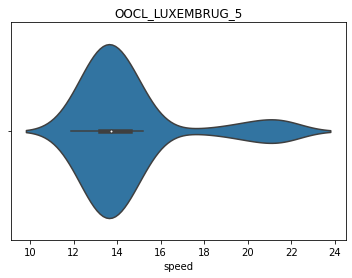

In [22]:
# use the seaborn violinplot function to visualize the distribution of the speed values
sns.violinplot(data=df, x='speed')
plt.title(f"OOCL_LUXEMBRUG_{voy_num}")

plt.show()

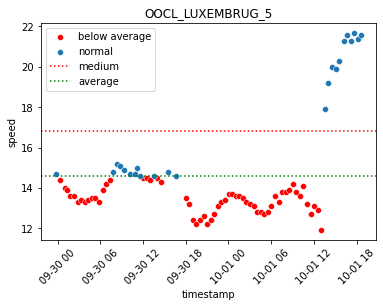

In [23]:
cosco_fos_26 = df
sns.scatterplot(
    data=cosco_fos_26[cosco_fos_26["speed"] < cosco_fos_26["speed"].mean()],
    x='timestamp',
    y='speed',
    color="red",
    label="below average")
sns.scatterplot(
    data=cosco_fos_26[cosco_fos_26["speed"] >= cosco_fos_26["speed"].mean()],
    x='timestamp',
    y='speed',
    label="normal")
plt.title(f"OOCL_LUXEMBRUG_{voy_num}")
plt.xticks(rotation=45)
# plt.axvline(x=cosco_fos_26["timestamp"].values[0],
#             color="pink",
#             linestyle="dashed",
#             label="dfdf")
# plt.axvline(x=cosco_fos_26["timestamp"].values[-1],
#             color="pink",
#             linestyle="dashed")
# plt.axhline(y=cosco_fos_23["speed"].mean(), linestyle="dotted")
plt.axhline(y=(cosco_fos_26["speed"].max() + cosco_fos_26["speed"].min()) / 2,
            linestyle="dotted",
            label="medium",
            color="red",
            )
plt.axhline(y=cosco_fos_26["speed"].mean(),
            linestyle="dotted",
            label="average",
            color="green",
            )
# use the seaborn violinplot function to visualize the distribution of the speed values
# sns.violinplot(data=cosco_fos_23, x='index', y='speed', inner="stick")
plt.legend()
plt.show()

## 6

In [24]:
df = oocl_lux_6
voy_num = 6

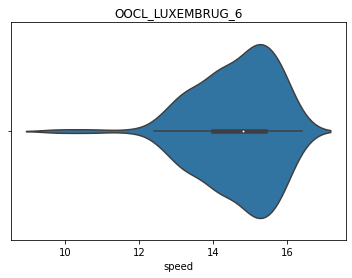

In [25]:
# use the seaborn violinplot function to visualize the distribution of the speed values
sns.violinplot(data=df, x='speed')
plt.title(f"OOCL_LUXEMBRUG_{voy_num}")

plt.show()

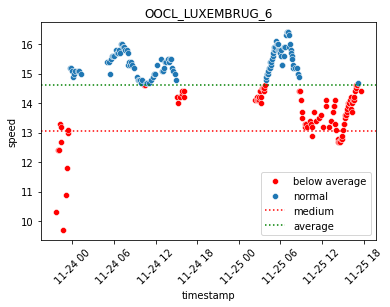

In [26]:
cosco_fos_26 = df
sns.scatterplot(
    data=cosco_fos_26[cosco_fos_26["speed"] < cosco_fos_26["speed"].mean()],
    x='timestamp',
    y='speed',
    color="red",
    label="below average")
sns.scatterplot(
    data=cosco_fos_26[cosco_fos_26["speed"] >= cosco_fos_26["speed"].mean()],
    x='timestamp',
    y='speed',
    label="normal")
plt.title(f"OOCL_LUXEMBRUG_{voy_num}")
plt.xticks(rotation=45)
# plt.axvline(x=cosco_fos_26["timestamp"].values[0],
#             color="pink",
#             linestyle="dashed",
#             label="dfdf")
# plt.axvline(x=cosco_fos_26["timestamp"].values[-1],
#             color="pink",
#             linestyle="dashed")
# plt.axhline(y=cosco_fos_23["speed"].mean(), linestyle="dotted")
plt.axhline(y=(cosco_fos_26["speed"].max() + cosco_fos_26["speed"].min()) / 2,
            linestyle="dotted",
            label="medium",
            color="red",
            )
plt.axhline(y=cosco_fos_26["speed"].mean(),
            linestyle="dotted",
            label="average",
            color="green",
            )
# use the seaborn violinplot function to visualize the distribution of the speed values
# sns.violinplot(data=cosco_fos_23, x='index', y='speed', inner="stick")
plt.legend()
plt.show()

# ETA 차이 확인

출발지점, 중간 지점, 도착 지점의 ETA 비교   
- proposed_ETA, AIS_ETA, TOS_ETA 비교군,
- ATA는 ATB 고려해서 계산. 2번에서 대기 시간 확인한 것 체크

OOCL_LUXEMBRUG_5
최대: 0 days 00:56:59.431864
평균: 0 days 00:22:59.531177951


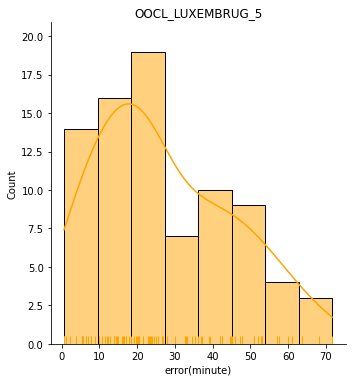

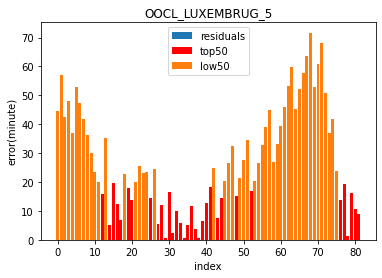

OOCL_LUXEMBRUG_6
최대: 0 days 01:52:50.338522
평균: 0 days 01:00:52.719962140


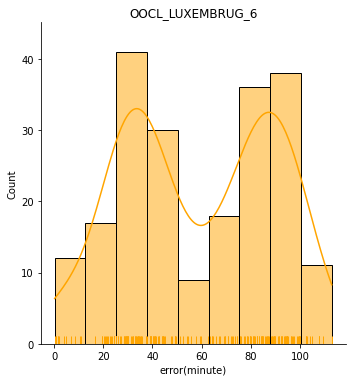

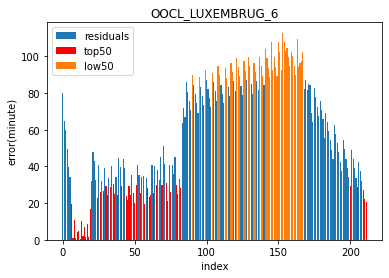

In [27]:
import seaborn as sns
import matplotlib.pyplot as plt

result_dfs = [oocl_lux_5, oocl_lux_6] # Replace with actual dataframes
voya_num = [5,6]
for i, df in enumerate(result_dfs):
    
    print(f"OOCL_LUXEMBRUG_{voya_num[i]}")
    print("최대:", df.loc[df.index[:-20]]["error"].max())
    print("평균:", df.loc[df.index[:-20]]["error"].mean())
    sns.displot(df["error"].values.astype(float) / (1e9 * 60), kde=True, rug=True, color="orange")
    plt.xlabel("error(minute)")
    plt.title(f"OOCL_LUXEMBRUG_{voya_num[i]}")
    plt.show()

    error_sorted = df.sort_values('error').dropna()
    high_threshold = error_sorted.iloc[50]["error"]
    low_threshold = error_sorted.iloc[-50]["error"]
    
    high_errors = df[df['error'] < high_threshold]
    low_errors = df[df['error'] > low_threshold]
    plt.bar(df["index"].values, df["error"].values.astype(float) /(1e9 * 60), label="residuals")
    plt.bar(high_errors["index"].values, high_errors["error"].values.astype(float) /(1e9 * 60), label="top50", color="red")
    plt.bar(low_errors["index"].values, low_errors["error"].values.astype(float) /(1e9 * 60), label="low50")
    
    plt.xlabel("index")
    plt.ylabel("error(minute)")
    plt.legend()
    plt.title(f"OOCL_LUXEMBRUG_{voya_num[i]}")
    plt.show()
    print("="*100)


## 5

In [28]:
OOLU006_df_eta_index = OOLU006_df["ETA"].drop_duplicates().index
OOLU006_df.loc[OOLU006_df_eta_index,["ETA","timestamp"]]

,ETA,timestamp
0,2022-09-30 16:00:00,2022-09-17 00:10:06.009198
259,2022-10-02 20:00:00,2022-09-22 15:46:13.672478
462,2022-10-02 09:00:00,2022-09-27 13:33:22.059004
465,2022-10-02 16:00:00,2022-09-27 15:03:30.720859
468,2022-10-02 11:00:00,2022-09-27 16:33:39.223895
554,2022-10-02 05:00:00,2022-09-29 12:03:03.144409
561,2022-10-01 07:00:00,2022-09-29 15:39:15.029719
562,2022-10-01 03:00:00,2022-09-29 16:03:25.073924
563,2022-10-02 03:00:00,2022-09-29 16:39:23.728935
564,2022-10-01 19:00:00,2022-09-29 17:07:32.744167


TOS_ETA
- 출항 전 : 2022-10-01 19:00:00	
- 2022-10-01 14:32:06.700433 이후 : 2022-10-01 23:00:00	
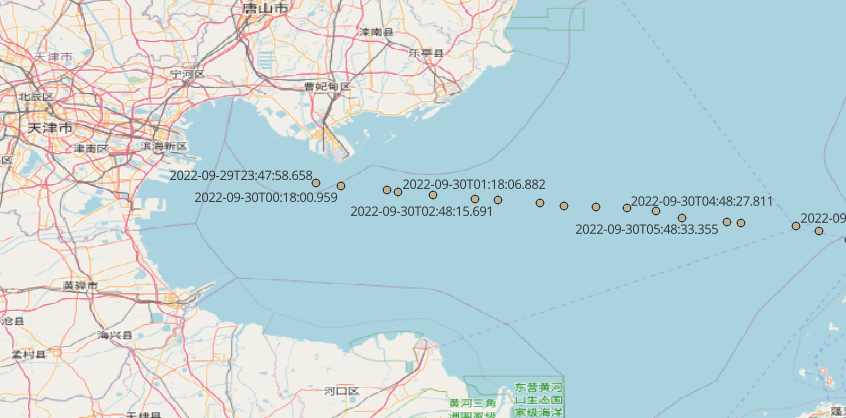
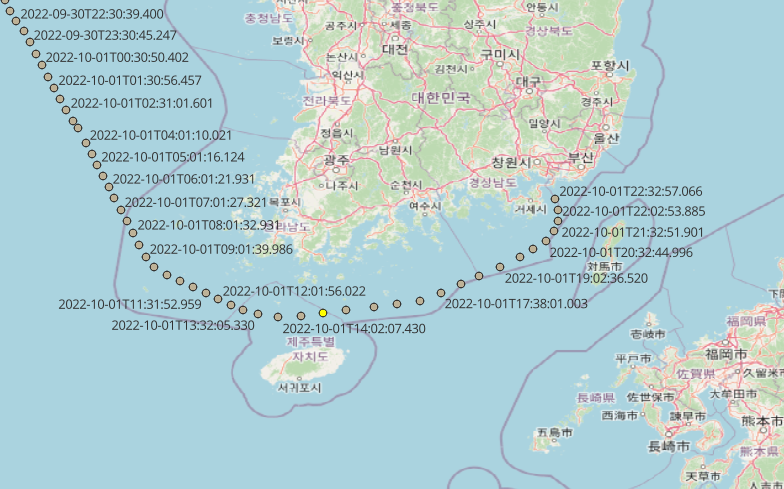

In [29]:
first_idx = oocl_lux_5[oocl_lux_5["timestamp"] < pd.to_datetime('2022-10-01 14:32:06.700433')].index
first_eta = '2022-10-01 19:00:00'

In [30]:
# second_idx = oocl_nw_1[
#     (oocl_nw_1["timestamp"] > pd.to_datetime('2022-09-16 12:04:48.553474'))
#     & (oocl_nw_1["timestamp"] <= pd.to_datetime(
#         '2022-09-16 18:39:39.945974'))].index
# second_eta = '2022-09-21 13:00:00'

In [31]:
third_idx = oocl_lux_5[oocl_lux_5["timestamp"] >= pd.to_datetime('2022-10-01 14:32:06.700433')].index
third_eta = '2022-10-01 23:00:00'

In [32]:
oocl_lux_5.loc[first_idx,"TOS_ETA"] = first_eta
# oocl_nw_1.loc[second_idx,"TOS_ETA"] = second_eta
oocl_lux_5.loc[third_idx,"TOS_ETA"] = third_eta


- ATB : 2022-10-02 00:20:00

In [33]:
pnit_history = pd.read_excel("pnit_berth_history_2.xlsx")
pnit_history[pnit_history["모선항차"] == "OOLU006"]

,선석,선사,모선항차,선사항차,Head (Bridge) Stern,선명,ROUTE,반입마감시한,접안(예정)일시,출항(예정)일시,양하,적하,Shift,상태
158,T2(P),OOL,OOLU006,098W/098W,22 (36) 42,OOCL LUXEMBOURG,CIX3,2022-10-01 18:00:00,2022-10-02 00:20:00,2022-10-02 21:00:00,1080,440,8,DEPARTED


In [34]:
oocl_lux_5["PNIT_ETB"] = '2022-10-02 00:20:00'

In [35]:
oocl_lux_5["PNIT_ETB"] = pd.to_datetime(oocl_lux_5["PNIT_ETB"])
oocl_lux_5["TOS_ETA"] = pd.to_datetime(oocl_lux_5["TOS_ETA"])
oocl_lux_5["waiting_time"] = abs(oocl_lux_5["PNIT_ETB"] - oocl_lux_5["ATA"] )
oocl_lux_5["ais_eta_error"] = abs(oocl_lux_5["ais_eta"] - oocl_lux_5["ATA"] )
oocl_lux_5["TOS_ETA_error"] = abs(oocl_lux_5["TOS_ETA"] - oocl_lux_5["ATA"] )

In [36]:
start_time = oocl_lux_5.loc[oocl_lux_5.index[0], "timestamp"]
end_time =oocl_lux_5.loc[oocl_lux_5.index[-1], "timestamp"]
middle_time = start_time + (end_time - start_time) / 2
oocl_lux_5['diff'] = abs(oocl_lux_5['timestamp'] - middle_time)
closest_index = oocl_lux_5['diff'].idxmin()

# Get the closest timestamp
closest_timestamp = oocl_lux_5.loc[closest_index, 'timestamp']

In [37]:
oocl_lux_5.drop(columns=["diff","eta",'mmsi','imo','CAPACITY'], inplace=True)

In [38]:
oocl_lux_5["ais_eta_error"].value_counts()

0 days 16:32:57.065631    71
0 days 20:32:57.065631    10
4 days 13:02:57.065631     1
Name: ais_eta_error, dtype: int64

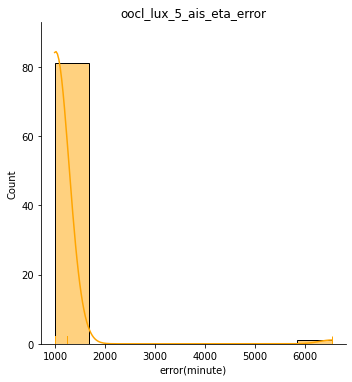

In [39]:
sns.displot(oocl_lux_5["ais_eta_error"].values.astype(float) / (1e9 * 60), kde=True, rug=True, color="orange")
plt.xlabel("error(minute)")
plt.title(f"oocl_lux_5_ais_eta_error")# sns.violinplot(data=cosco_fos_23, x='ais_eta_error_numeric')

plt.show()

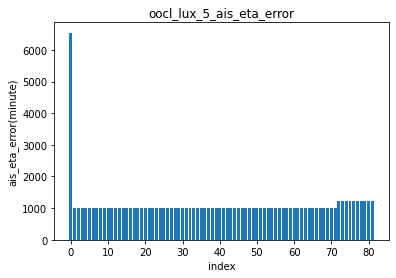

In [40]:
plt.bar(oocl_lux_5["index"].values, oocl_lux_5["ais_eta_error"].values.astype(float) /(1e9 * 60))
# sns.barplot(data=cosco_fos_23, x="index", y='ais_eta_error_numeric')

plt.xlabel("index")
plt.ylabel("ais_eta_error(minute)")
plt.yticks()
plt.title(f"oocl_lux_5_ais_eta_error")
plt.show()

In [41]:
oocl_lux_5["TOS_ETA_error"].value_counts()

0 days 03:32:57.065631    73
0 days 00:27:02.934369     9
Name: TOS_ETA_error, dtype: int64

In [42]:
cosco_fos_23 = oocl_lux_5

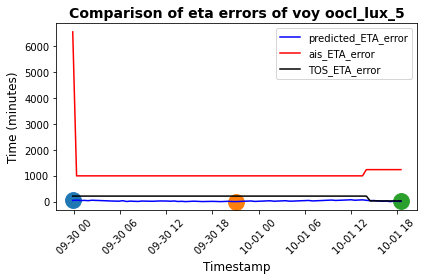

In [43]:
cosco_fos_23['error_minutes'] = cosco_fos_23['error'].dt.total_seconds() / 60
cosco_fos_23['ais_eta_error_minutes'] = cosco_fos_23['ais_eta_error'].dt.total_seconds() / 60
cosco_fos_23['TOS_ETA_error_minutes'] = cosco_fos_23['TOS_ETA_error'].dt.total_seconds() / 60

# plot the comparison using seaborn lineplot
sns.lineplot(data=cosco_fos_23, x="timestamp", y='error_minutes', color='blue', label="predicted_ETA_error")
sns.lineplot(data=cosco_fos_23, x="timestamp", y='ais_eta_error_minutes', color='red', label="ais_ETA_error")
sns.lineplot(data=cosco_fos_23, x="timestamp", y='TOS_ETA_error_minutes', color='black', label="TOS_ETA_error")

# plt.axvline(x=cosco_fos_23.timestamp[0],ymax=0.9,ymin=0.1,
#             linestyle="dotted",
#             label="medium",
#             color="red",
#             )

plt.scatter(x=cosco_fos_23.timestamp[0], y=cosco_fos_23.error_minutes[0], s=250)
# plt.scatter(x=cosco_fos_23.timestamp[0], y=cosco_fos_23.ais_eta_error_minutes[0])
# plt.scatter(x=cosco_fos_23.timestamp[0], y=cosco_fos_23.TOS_ETA_error_minutes[0])
plt.scatter(x=cosco_fos_23.timestamp[closest_index], y=cosco_fos_23.error_minutes[closest_index], s=250)
# plt.scatter(x=cosco_fos_23.timestamp[closest_index], y=cosco_fos_23.ais_eta_error_minutes[closest_index])
# plt.scatter(x=cosco_fos_23.timestamp[closest_index], y=cosco_fos_23.TOS_ETA_error_minutes[closest_index])
plt.scatter(x=cosco_fos_23.timestamp[cosco_fos_23.index[-1]], y=cosco_fos_23.error_minutes[cosco_fos_23.index[-1]], s=250)
# plt.scatter(x=cosco_fos_23.timestamp[cosco_fos_23.index[-1]], y=cosco_fos_23.ais_eta_error_minutes[cosco_fos_23.index[-1]])
# plt.scatter(x=cosco_fos_23.timestamp[cosco_fos_23.index[-1]], y=cosco_fos_23.TOS_ETA_error_minutes[cosco_fos_23.index[-1]])

# customize the plot to make it visually appealing
plt.xlabel('Timestamp', fontsize=12)
plt.ylabel('Time (minutes)', fontsize=12)
plt.title('Comparison of eta errors of voy oocl_lux_5', fontsize=14, fontweight='bold')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [44]:
cosco_fos_23.loc[[cosco_fos_23.index[0],closest_index,cosco_fos_23.index[-1]],['vessel_name','timestamp','ETA','ATA','waiting_time','error','ais_eta','TOS_ETA','PNIT_ETB','ais_eta_error','TOS_ETA_error']]

,vessel_name,timestamp,ETA,ATA,waiting_time,error,ais_eta,TOS_ETA,PNIT_ETB,ais_eta_error,TOS_ETA_error
0,OOCL LUXEMBOURG,2022-09-29 23:47:58.658020,2022-10-01 21:48:18.127093,2022-10-01 22:32:57.065631,0 days 01:47:02.934369,0 days 00:44:38.938538,2022-09-27 09:30:00,2022-10-01 19:00:00,2022-10-02 00:20:00,4 days 13:02:57.065631,0 days 03:32:57.065631
38,OOCL LUXEMBOURG,2022-09-30 21:00:31.273870,2022-10-01 22:33:35.154067,2022-10-01 22:32:57.065631,0 days 01:47:02.934369,0 days 00:00:38.088436,2022-10-01 06:00:00,2022-10-01 19:00:00,2022-10-02 00:20:00,0 days 16:32:57.065631,0 days 03:32:57.065631
81,OOCL LUXEMBOURG,2022-10-01 18:32:33.411872,2022-10-01 22:24:07.639941,2022-10-01 22:32:57.065631,0 days 01:47:02.934369,0 days 00:08:49.425690,2022-10-01 02:00:00,2022-10-01 23:00:00,2022-10-02 00:20:00,0 days 20:32:57.065631,0 days 00:27:02.934369


In [45]:
voyage_list.append(5)
waiting_list.append(cosco_fos_23.loc[0,"waiting_time"])

## 6

In [46]:
OOLU007_df_eta_index = OOLU007_df["ETA"].drop_duplicates().index
OOLU007_df.loc[OOLU007_df_eta_index,["ETA","timestamp"]]

,ETA,timestamp
0,2022-11-25 16:00:00,2022-11-02 14:47:18.553373
3816,2022-11-26 19:00:00,2022-11-17 15:58:53.586268
3822,2022-11-26 11:00:00,2022-11-17 16:29:11.072788
4884,2022-11-25 23:00:00,2022-11-21 11:15:14.380584
4886,2022-11-26 09:00:00,2022-11-21 11:25:20.279739
5140,2022-11-26 03:00:00,2022-11-22 09:29:19.265369


TOS_ETA
- 출항 전 : 2022-11-26 03:00:00	
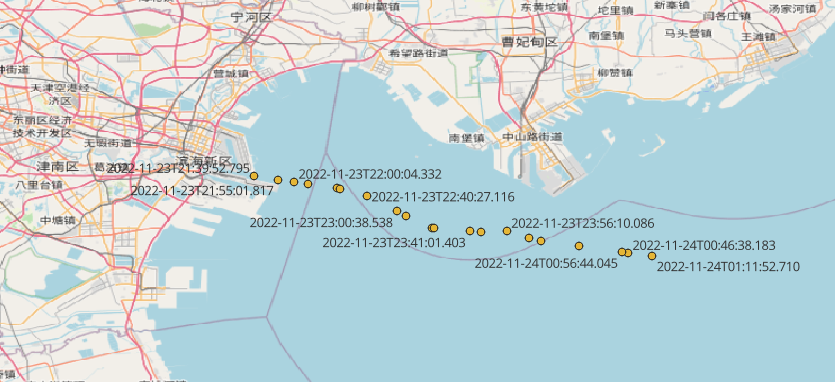

In [47]:
# first_idx = oocl_nw_1[oocl_nw_1["timestamp"] < pd.to_datetime('2022-09-16 12:04:48.553474')].index
# first_eta = '2022-09-19 09:00:00'

In [48]:
# second_idx = oocl_nw_1[
#     (oocl_nw_1["timestamp"] > pd.to_datetime('2022-09-16 12:04:48.553474'))
#     & (oocl_nw_1["timestamp"] <= pd.to_datetime(
#         '2022-09-16 18:39:39.945974'))].index
# second_eta = '2022-09-21 13:00:00'

In [49]:
# third_idx = oocl_nw_1[oocl_nw_1["timestamp"] >= pd.to_datetime('2022-09-16 18:39:39.945974')].index
# third_eta = '2022-09-21 06:00:00'

In [50]:
# oocl_nw_1.loc[first_idx,"TOS_ETA"] = first_eta
# oocl_nw_1.loc[second_idx,"TOS_ETA"] = second_eta
# oocl_nw_1.loc[third_idx,"TOS_ETA"] = third_eta


In [51]:
oocl_lux_6["TOS_ETA"] = '2022-11-26 03:00:00'

- ATB : 2022-11-11 14:25:00

In [52]:
pnit_history = pd.read_excel("pnit_berth_history_2.xlsx")
pnit_history[pnit_history["모선항차"] == "OOLU007"]['접안(예정)일시'].values[0]

numpy.datetime64('2022-11-26T00:30:00.000000000')

In [53]:
oocl_lux_6["PNIT_ETB"] = pnit_history[pnit_history["모선항차"] == "OOLU007"]['접안(예정)일시'].values[0]

In [54]:
oocl_lux_6["PNIT_ETB"] = pd.to_datetime(oocl_lux_6["PNIT_ETB"])
oocl_lux_6["TOS_ETA"] = pd.to_datetime(oocl_lux_6["TOS_ETA"])
oocl_lux_6["waiting_time"] = abs(oocl_lux_6["PNIT_ETB"] - oocl_lux_6["ATA"] )
oocl_lux_6["ais_eta_error"] = abs(oocl_lux_6["ais_eta"] - oocl_lux_6["ATA"] )
oocl_lux_6["TOS_ETA_error"] = abs(oocl_lux_6["TOS_ETA"] - oocl_lux_6["ATA"] )

In [55]:
start_time = oocl_lux_6.loc[oocl_lux_6.index[0], "timestamp"]
end_time =oocl_lux_6.loc[oocl_lux_6.index[-1], "timestamp"]
middle_time = start_time + (end_time - start_time) / 2
oocl_lux_6['diff'] = abs(oocl_lux_6['timestamp'] - middle_time)
closest_index = oocl_lux_6['diff'].idxmin()

# Get the closest timestamp
closest_timestamp = oocl_lux_6.loc[closest_index, 'timestamp']

In [56]:
oocl_lux_6.drop(columns=["diff","eta",'mmsi','imo','CAPACITY'], inplace=True)

In [57]:
oocl_lux_6["ais_eta_error"].value_counts()

0 days 19:46:07.464304    212
Name: ais_eta_error, dtype: int64

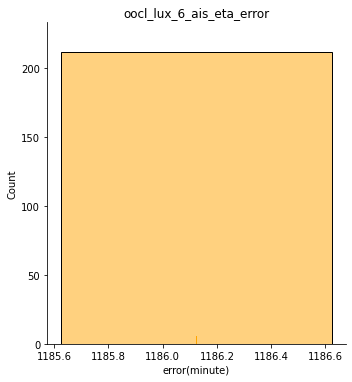

In [58]:
sns.displot(oocl_lux_6["ais_eta_error"].values.astype(float) / (1e9 * 60), kde=True, rug=True, color="orange")
plt.xlabel("error(minute)")
plt.title(f"oocl_lux_6_ais_eta_error")# sns.violinplot(data=cosco_fos_23, x='ais_eta_error_numeric')

plt.show()

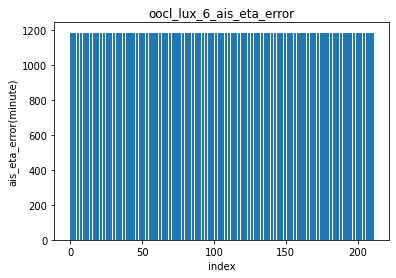

In [59]:
plt.bar(oocl_lux_6["index"].values, oocl_lux_6["ais_eta_error"].values.astype(float) /(1e9 * 60))
# sns.barplot(data=cosco_fos_23, x="index", y='ais_eta_error_numeric')

plt.xlabel("index")
plt.ylabel("ais_eta_error(minute)")
plt.yticks()
plt.title(f"oocl_lux_6_ais_eta_error")
plt.show()

In [60]:
oocl_lux_6["TOS_ETA_error"].value_counts()

0 days 05:13:52.535696    212
Name: TOS_ETA_error, dtype: int64

In [61]:
cosco_fos_23 = oocl_lux_6

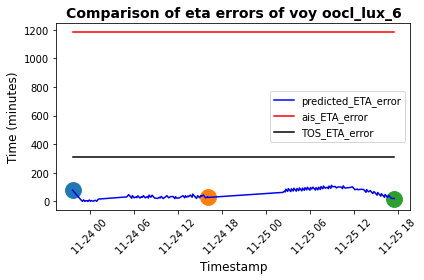

In [62]:
cosco_fos_23['error_minutes'] = cosco_fos_23['error'].dt.total_seconds() / 60
cosco_fos_23['ais_eta_error_minutes'] = cosco_fos_23['ais_eta_error'].dt.total_seconds() / 60
cosco_fos_23['TOS_ETA_error_minutes'] = cosco_fos_23['TOS_ETA_error'].dt.total_seconds() / 60

# plot the comparison using seaborn lineplot
sns.lineplot(data=cosco_fos_23, x="timestamp", y='error_minutes', color='blue', label="predicted_ETA_error")
sns.lineplot(data=cosco_fos_23, x="timestamp", y='ais_eta_error_minutes', color='red', label="ais_ETA_error")
sns.lineplot(data=cosco_fos_23, x="timestamp", y='TOS_ETA_error_minutes', color='black', label="TOS_ETA_error")

# plt.axvline(x=cosco_fos_23.timestamp[0],ymax=0.9,ymin=0.1,
#             linestyle="dotted",
#             label="medium",
#             color="red",
#             )

plt.scatter(x=cosco_fos_23.timestamp[0], y=cosco_fos_23.error_minutes[0], s=250)
# plt.scatter(x=cosco_fos_23.timestamp[0], y=cosco_fos_23.ais_eta_error_minutes[0])
# plt.scatter(x=cosco_fos_23.timestamp[0], y=cosco_fos_23.TOS_ETA_error_minutes[0])
plt.scatter(x=cosco_fos_23.timestamp[closest_index], y=cosco_fos_23.error_minutes[closest_index], s=250)
# plt.scatter(x=cosco_fos_23.timestamp[closest_index], y=cosco_fos_23.ais_eta_error_minutes[closest_index])
# plt.scatter(x=cosco_fos_23.timestamp[closest_index], y=cosco_fos_23.TOS_ETA_error_minutes[closest_index])
plt.scatter(x=cosco_fos_23.timestamp[cosco_fos_23.index[-1]], y=cosco_fos_23.error_minutes[cosco_fos_23.index[-1]], s=250)
# plt.scatter(x=cosco_fos_23.timestamp[cosco_fos_23.index[-1]], y=cosco_fos_23.ais_eta_error_minutes[cosco_fos_23.index[-1]])
# plt.scatter(x=cosco_fos_23.timestamp[cosco_fos_23.index[-1]], y=cosco_fos_23.TOS_ETA_error_minutes[cosco_fos_23.index[-1]])

# customize the plot to make it visually appealing
plt.xlabel('Timestamp', fontsize=12)
plt.ylabel('Time (minutes)', fontsize=12)
plt.title('Comparison of eta errors of voy oocl_lux_6', fontsize=14, fontweight='bold')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [63]:
cosco_fos_23.loc[[cosco_fos_23.index[0],closest_index,cosco_fos_23.index[-1]],['vessel_name','timestamp','ETA','ATA','waiting_time','error','ais_eta','TOS_ETA','PNIT_ETB','ais_eta_error','TOS_ETA_error']]

,vessel_name,timestamp,ETA,ATA,waiting_time,error,ais_eta,TOS_ETA,PNIT_ETB,ais_eta_error,TOS_ETA_error
0,OOCL LUXEMBOURG,2022-11-23 21:39:52.794963,2022-11-25 20:26:14.941946,2022-11-25 21:46:07.464304,0 days 02:43:52.535696,0 days 01:19:52.522358,2022-11-25 02:00:00,2022-11-26 03:00:00,2022-11-26 00:30:00,0 days 19:46:07.464304,0 days 05:13:52.535696
82,OOCL LUXEMBOURG,2022-11-24 16:10:18.163542,2022-11-25 21:17:49.560002,2022-11-25 21:46:07.464304,0 days 02:43:52.535696,0 days 00:28:17.904302,2022-11-25 02:00:00,2022-11-26 03:00:00,2022-11-26 00:30:00,0 days 19:46:07.464304,0 days 05:13:52.535696
211,OOCL LUXEMBOURG,2022-11-25 17:33:48.365239,2022-11-25 21:25:22.593308,2022-11-25 21:46:07.464304,0 days 02:43:52.535696,0 days 00:20:44.870996,2022-11-25 02:00:00,2022-11-26 03:00:00,2022-11-26 00:30:00,0 days 19:46:07.464304,0 days 05:13:52.535696


In [64]:
voyage_list.append(6)
waiting_list.append(cosco_fos_23.loc[0,"waiting_time"])

# waiting time

In [65]:
waiting_list = pd.to_timedelta(waiting_list)

In [66]:
voyage_list.append("avg")
waiting_list = waiting_list.values.astype(float) / (1e9 * 60)

In [67]:
waiting_list = np.append(waiting_list, np.mean(waiting_list))

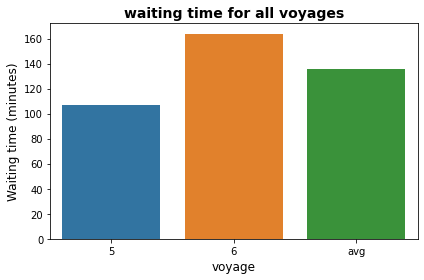

In [68]:
sns.barplot(x=voyage_list, y=waiting_list)
plt.xlabel('voyage', fontsize=12)
plt.ylabel('Waiting time (minutes)', fontsize=12)
plt.title('waiting time for all voyages', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()